In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import matplotlib.dates as mdates
import pickle
import warnings

#from torch.utils.tensorboard import SummaryWriter
from torch_geometric.nn import GCNConv
from sklearn.neighbors import BallTree
from scipy.spatial import KDTree
from torch_geometric.data import Data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm.notebook import tqdm


# Data Cleaning

In [3]:
"""
Get data
"""
pd.set_option('display.max_columns', None)  # None means all columns will be displayed

df = pd.read_parquet('../../Datasets/data_processed_half_Basti_final.parq')


#-----------------------One hot encode the 'owner' column-----------------------
df = pd.get_dummies(df, columns=['owner'])


#-----------------------Data cleaning-----------------------
# Drop columns and charging stations  
df = df.drop(['plugType1'], axis=1)  

# Remove coordinates
coordinates_to_remove = [
    (9.695102, 56.784101),
    (10.177534, 56.137189),
    (12.488927, 55.765375),
    (12.586730, 56.025982),
    (12.593150, 55.701301),
    (8.141860, 55.555610),
    (12.163113, 55.489025),
    (8.620159, 56.361676),
]

for longitude, latitude in coordinates_to_remove:
    df = df[~((df['longitude'] == longitude) & (df['latitude'] == latitude))]

print("Column Names:", df.columns.tolist())
display(df)



Column Names: ['timestamp_rounded', 'longitude', 'latitude', 'plugType2', 'plugCCS', 'plugTesla', 'plugChademo', 'gravity', 'traffic', 'apartments', 'cinemas', 'clinics', 'colleges', 'communityCentres', 'conferenceCentres', 'dentists', 'eventsVenues', 'fastFoods', 'hospitals', 'hotels', 'houses', 'leisureFitnessCentres', 'leisureStadiums', 'motorwayLinks', 'placesOfWorship', 'restaurants', 'shopMalls', 'shopSupermarkets', 'sportsCentres', 'sportsHalls', 'stadiums', 'substationDistributions', 'theatres', 'universities', 'ratios_length', 'minCapacity', 'maxCapacity', 'status_3_ratio', 'hours_elapsed', 'owner_Allego', 'owner_Circle K', 'owner_Clever', 'owner_Drivee', 'owner_E.ON', 'owner_E.ON Drive & Clever', 'owner_EVBox B.V. ', 'owner_IONITY', 'owner_Monta', 'owner_Q8', 'owner_Shell Recharge', 'owner_Spirii', 'owner_Tesla', 'owner_Tesla (Open for all EV)']


,timestamp_rounded,longitude,latitude,plugType2,plugCCS,plugTesla,plugChademo,gravity,traffic,apartments,cinemas,clinics,colleges,communityCentres,conferenceCentres,dentists,eventsVenues,fastFoods,hospitals,hotels,houses,leisureFitnessCentres,leisureStadiums,motorwayLinks,placesOfWorship,restaurants,shopMalls,shopSupermarkets,sportsCentres,sportsHalls,stadiums,substationDistributions,theatres,universities,ratios_length,minCapacity,maxCapacity,status_3_ratio,hours_elapsed,owner_Allego,owner_Circle K,owner_Clever,owner_Drivee,owner_E.ON,owner_E.ON Drive & Clever,owner_EVBox B.V.,owner_IONITY,owner_Monta,owner_Q8,owner_Shell Recharge,owner_Spirii,owner_Tesla,owner_Tesla (Open for all EV)
2259,2023-08-10 13:30:00,8.213788,56.705280,8,2,0,0,6626.62,10.8433,585.146,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.9235,5954.700,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,10.0,11.0,80.0,0.40,0.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2260,2023-08-10 14:00:00,8.213788,56.705280,8,2,0,0,6626.62,10.8433,585.146,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.9235,5954.700,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,10.0,11.0,80.0,0.40,0.5,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2261,2023-08-10 14:30:00,8.213788,56.705280,8,2,0,0,6626.62,10.8433,585.146,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.9235,5954.700,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,10.0,11.0,80.0,0.40,1.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2262,2023-08-10 15:00:00,8.213788,56.705280,8,2,0,0,6626.62,10.8433,585.146,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.9235,5954.700,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,10.0,11.0,80.0,0.50,1.5,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2263,2023-08-10 15:30:00,8.213788,56.705280,8,2,0,0,6626.62,10.8433,585.146,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.9235,5954.700,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,10.0,11.0,80.0,0.50,2.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903107,2023-10-16 09:00:00,12.659088,55.595629,0,2,0,0,26745.10,0.0000,386.782,2.05985,0.0,0.0,0.0,0.0,6.13375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,198.6430,187.923,2933.2,16313.9,0.0,0.0,0.0,6716.45,0.0,0.0,2.0,300.0,300.0,0.50,1603.5,False,False,True,False,False,False,False,False,False,False,False,False,False,False
903108,2023-10-16 09:30:00,12.659088,55.595629,0,2,0,0,26745.10,0.0000,386.782,2.05985,0.0,0.0,0.0,0.0,6.13375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,198.6430,187.923,2933.2,16313.9,0.0,0.0,0.0,6716.45,0.0,0.0,2.0,300.0,300.0,0.50,1604.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False
903109,2023-10-16 10:00:00,12.659088,55.595629,0,2,0,0,26745.10,0.0000,386.782,2.05985,0.0,0.0,0.0,0.0,6.13375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,198.6430,187.923,2933.2,16313.9,0.0,0.0,0.0,6716.45,0.0,0.0,2.0,300.0,300.0,0.50,1604.5,False,False,True,False,False,False,False,False,False,False,False,False,False,False
903110,2023-10-16 10:30:00,12.659088,55.595629,0,2,0,0,26745.10,0.0000,386.782,2.05985,0.0,0.0,0.0,0.0,6.13375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,198.6430,187.923,2933.2,16313.9,0.0,0.0,0.0,6716.45,0.0,0.0,2.0,300.0,300.0,0.75,1605.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False


# Add New Stations

In [4]:
"""
Define new stations

new_stations = pd.DataFrame({
    'longitude':                    [8.141847, 10.190804, 11.449852],
    'latitude':                     [55.555547, 56.171794, 56.348656],
    'plugType2':                    [2, 4, 1], 
    'plugCCS':                      [2, 4, 0], 
    'plugTesla':                    [0, 0, 0],  
    'plugChademo':                  [0, 4, 0],  
    'gravity':                      [13462.7, 25000, 0.0],   
    'traffic':                      [0.0, 500, 0],   
    'apartments':                   [215.249, 215.249, 0.0],   
    'cinemas':                      [0.0, 0.0, 0.0],   
    'clinics':                      [0.0, 0.0, 0.0],   
    'colleges':                     [0.0, 0.0, 0.0],   
    'communityCentres':             [0.0, 0.0, 0.0],   
    'conferenceCentres':            [0.0, 2000, 0.0],   
    'dentists':                     [0.0, 100, 0.0],  
    'eventsVenues':                 [0.0, 0.0, 0.0],   
    'fastFoods':                    [0.0, 500, 0.0],   
    'hospitals':                    [0.0, 0.0, 0.0],           
    'hotels':                       [0.0, 0.0, 0.0],           
    'houses':                       [0.0, 100, 0.0],           
    'leisureFitnessCentres':        [0.0, 1000, 0.0],           
    'leisureStadiums':              [0.0, 0.0, 0.0],           
    'motorwayLinks':                [0.0, 0.0, 0.0],           
    'placesOfWorship':              [1821.540	, 0.0, 0.0],           
    'restaurants':                  [764.615	, 250, 0.0],           
    'shopMalls':                    [0.0, 10000, 0.0],           
    'shopSupermarkets':             [10661.3, 10000, 0.0],           
    'sportsCentres':                [0.0, 0.0, 0.0],           
    'sportsHalls':                  [0.0, 0.0, 0.0],           
    'stadiums':                     [0.0, 0.0, 0.0],           
    'substationDistributions':      [0.0, 0.0, 0.0],           
    'theatres':                     [13462.7, 0.0, 0.0],           
    'universities':                 [0.0, 16313.9, 0.0],           
    'ratios_length':                [4.0, 4.0, 0.0],    
    'minCapacity':                  [11.0, 11.0, 11.0],    
    'maxCapacity':                  [150.0, 150.0, 11.0],    
    'owner_Allego':                 [False, False, False],    
    'owner_Circle K':               [False, False, False],    
    'owner_Clever':                 [True, True, False],    
    'owner_Drivee':                 [False, False, False],    
    'owner_E.ON':                  [False, False, False],    
    'owner_E.ON Drive & Clever':    [False, False, False],    
    'owner_EVBox B.V. ':            [False, False, False],    
    'owner_IONITY':                 [False, False, False],    
    'owner_Monta':                  [False, False, True],    
    'owner_Q8':                     [False, False, False],    
    'owner_Shell Recharge':         [False, False, False],    
    'owner_Spirii':                 [False, False, False],    
    'owner_Tesla':                  [False, False, False],    
    'owner_Tesla (Open for all EV)':[False, False, False]
})
"""
# Define the DataFrame for new stations
new_stations = pd.DataFrame({
    'longitude': [8.141860, 12.163113, 8.620159],
    'latitude': [55.555610, 55.489025, 56.361676], 
    
})


# Concatenate the new stations DataFrame with the existing DataFrame
#df = pd.concat([df, new_stations], ignore_index=True)
#display(df)
#print(df.columns.tolist())

# Get Similar Stations Average

### Nearest Neighbour

In [5]:
"""
Helper functions 
"""
# Function to calculate weights from distances
def calculate_edge_weights(distances):
    epsilon = 1e-10
    return 1.0 / (distances + epsilon)

#Function to calculate cartesian coordinates 
def latlon_to_xyz(latitude, longitude):
    lat_rad = np.radians(latitude)
    lon_rad = np.radians(longitude)
    x = np.cos(lat_rad) * np.cos(lon_rad)
    y = np.cos(lat_rad) * np.sin(lon_rad)
    z = np.sin(lat_rad)
    return x, y, z


In [6]:
"""
Finding nearest neighbour for each new charging station 
"""
coordinates = df[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)

# make dictionary to store the indexing of the charging stations 
index_mapping = {tuple(row): i for i, row in enumerate(coordinates[['latitude', 'longitude']].values)}
print(index_mapping)

#Converting coordinates to cartesian 
new_station_coords = np.array([latlon_to_xyz(lat, lon) for lat, lon in zip(new_stations['latitude'], new_stations['longitude'])])
existing_coords = np.array([latlon_to_xyz(lat, lon) for lat, lon in coordinates.to_numpy()])

tree = KDTree(existing_coords)

# Find the nearest 5 neighbors for each new station and calculate weights 
N = 5
distances, indices = tree.query(new_station_coords, k=N)
weights = np.array([calculate_edge_weights(distance) for distance in distances])

#Optional
display(indices)
display(distances)
display(weights)

{(56.70528, 8.213788): 0, (56.700175, 8.221635): 1, (56.781686, 8.23264): 2, (56.094496, 8.23574): 3, (56.092085, 8.242567): 4, (56.196524, 8.298722): 5, (56.549673, 8.302795): 6, (56.55181, 8.310629): 7, (55.613885, 8.325843): 8, (56.950043, 8.37408): 9, (55.438328, 8.385841): 10, (56.751527, 8.417567): 11, (55.471802, 8.434331): 12, (55.472953, 8.435814): 13, (55.465674, 8.444136): 14, (55.465691, 8.445434): 15, (55.510032, 8.456897): 16, (57.043306, 8.481117): 17, (55.478315, 8.493108): 18, (55.610463, 8.493445): 19, (55.146434, 8.495552): 20, (55.521225, 8.548019): 21, (56.486855, 8.583807): 22, (55.524597, 8.589284): 23, (56.493334, 8.591714): 24, (56.480421, 8.606704): 25, (57.115455, 8.60822): 26, (56.377499, 8.620042): 27, (56.376929, 8.621127): 28, (56.36633, 8.637648): 29, (56.954006, 8.692057): 30, (56.951909, 8.692122): 31, (56.955035, 8.696964): 32, (55.330435, 8.764603): 33, (55.158749, 8.769447): 34, (55.333163, 8.770313): 35, (56.390391, 8.805212): 36, (56.787214, 8.829

array([[  8,  10,  16,  12,  13],
       [296, 295, 294, 299, 297],
       [ 29,  28,  27,  36,  25]])

array([[2.08044285e-03, 3.16357669e-03, 3.21181566e-03, 3.23931165e-03,
        3.24337143e-03],
       [9.70809498e-06, 1.78798704e-05, 6.97336155e-05, 2.57724449e-04,
        7.49598798e-04],
       [1.87576797e-04, 2.66379459e-04, 2.76165762e-04, 1.85735288e-03,
        2.07655675e-03]])

array([[   480.66686843,    316.09790667,    311.35036199,
           308.70755154,    308.32113802],
       [103005.75979274,  55928.50420543,  14340.26556959,
          3880.11154559,   1334.04678517],
       [  5331.14695018,   3754.04179734,   3621.01235592,
           538.40062219,    481.56639675]])

In [7]:
"""
Find neighbouring charging stations for new charging stations 
"""
# Reverse the index_mapping to get coordinates from indices
reverse_index_mapping = {v: k for k, v in index_mapping.items()}

# Retrieve coordinates for each list of indices for new stations
new_station_neighbors_coords = []

# Iterative through indices
for index_list in indices:
    neighbor_coords = [reverse_index_mapping[idx] for idx in index_list]
    new_station_neighbors_coords.append(neighbor_coords)

# Display the coordinates for each new station's neighbors
for i, coords in enumerate(new_station_neighbors_coords):
    print(f"Coordinates for neighbors of new station {i}: {coords}")


Coordinates for neighbors of new station 0: [(55.613885, 8.325843), (55.438328, 8.385841), (55.510032, 8.456897), (55.471802, 8.434331), (55.472953, 8.435814)]
Coordinates for neighbors of new station 1: [(55.488631, 12.16242), (55.489341, 12.161393), (55.486708, 12.157368), (55.4824, 12.186404), (55.446462, 12.173246)]
Coordinates for neighbors of new station 2: [(56.36633, 8.637648), (56.376929, 8.621127), (56.377499, 8.620042), (56.390391, 8.805212), (56.480421, 8.606704)]


In [8]:
"""
Make new charging station 
"""
# Preparing DataFrame to store results
new_station_time_series = []

In [9]:
"""
Make weighted average time series
"""
# Get all unique timestamps from existing data
timestamps = df['timestamp_rounded'].unique()

# Preparing DataFrame to store results
new_station_time_series = []

# Iterate through each new station and its neighbors
for i, neighbor_coords in enumerate(new_station_neighbors_coords):
    # Get the weights for the current set of neighbors
    current_weights = weights[i]

    for timestamp in timestamps:
        # Filter 'df' for each neighbor at the current timestamp
        status_ratios = []
        
        for j, coord in enumerate(neighbor_coords):
            lat, lon = coord
            neighbor_data = df[(df['latitude'] == lat) & (df['longitude'] == lon) & (df['timestamp_rounded'] == timestamp)]
            if not neighbor_data.empty:
                # Assume we take the mean if there are multiple entries for some reason
                status_ratios.append(neighbor_data['status_3_ratio'].mean())

        # Calculate weighted average if there are any ratios available
        if status_ratios:
            weighted_status_ratio = np.average(status_ratios, weights=current_weights[:len(status_ratios)])
            new_station_time_series.append({
                'timestamp_rounded': timestamp,
                'latitude': new_stations.iloc[i]['latitude'],
                'longitude': new_stations.iloc[i]['longitude'],
                'status_3_ratio': weighted_status_ratio
            })

# Convert list to DataFrame
new_stations_time_series_df = pd.DataFrame(new_station_time_series)



In [20]:
"""
Add hours_elapsed column
"""
# Group by 'longitude' and 'latitude', then transform each group
new_stations_time_series_df['hours_elapsed'] = new_stations_time_series_df.groupby(['longitude', 'latitude'])['timestamp_rounded'].transform(lambda x: (x - x.min()).dt.total_seconds() / 3600)

new_stations_time_series_df = new_stations_time_series_df.sort_values(by=['longitude', 'latitude', 'timestamp_rounded'])


# Now 'df_grouped' contains a 'minutes_elapsed' column representing the minutes since the first sample for each station
display(new_stations_time_series_df)

,timestamp_rounded,latitude,longitude,status_3_ratio,hours_elapsed
0,2023-08-10 13:30:00,55.555610,8.141860,0.271022,0.0
1,2023-08-10 14:00:00,55.555610,8.141860,0.134938,0.5
2,2023-08-10 14:30:00,55.555610,8.141860,0.105839,1.0
3,2023-08-10 15:00:00,55.555610,8.141860,0.235527,1.5
4,2023-08-10 15:30:00,55.555610,8.141860,0.205702,2.0
...,...,...,...,...,...
4496,2023-10-16 09:30:00,55.489025,12.163113,0.291166,1604.0
4497,2023-10-16 10:00:00,55.489025,12.163113,0.274073,1604.5
4498,2023-10-16 10:30:00,55.489025,12.163113,0.285595,1605.0
4499,2023-10-16 11:00:00,55.489025,12.163113,0.416725,1605.5


### Verification

In [21]:
"""
Verify the new stations
"""

    #'longitude': [8.141860, 12.163113, 8.620159],
    #"'latitude': [55.555610, 55.489025, 56.361676], 
    
# Assuming new_stations_time_series_df is your DataFrame
# Specify the longitude and latitude of the charging station you want to check
specific_longitude = 8.141860  # Example longitude
specific_latitude = 55.555610  # Example latitude

# Filter data
specific_station_data = new_stations_time_series_df[
    (new_stations_time_series_df['longitude'] == specific_longitude) & 
    (new_stations_time_series_df['latitude'] == specific_latitude)
]

# Sort data by timestamp
specific_station_data_sorted = specific_station_data.sort_values(by='timestamp_rounded')
print(specific_station_data_sorted)




       timestamp_rounded  latitude  longitude  status_3_ratio  hours_elapsed
0    2023-08-10 13:30:00  55.55561    8.14186        0.271022            0.0
1    2023-08-10 14:00:00  55.55561    8.14186        0.134938            0.5
2    2023-08-10 14:30:00  55.55561    8.14186        0.105839            1.0
3    2023-08-10 15:00:00  55.55561    8.14186        0.235527            1.5
4    2023-08-10 15:30:00  55.55561    8.14186        0.205702            2.0
...                  ...       ...        ...             ...            ...
2225 2023-10-16 09:30:00  55.55561    8.14186        0.302374         1604.0
2226 2023-10-16 10:00:00  55.55561    8.14186        0.226590         1604.5
2227 2023-10-16 10:30:00  55.55561    8.14186        0.136293         1605.0
2228 2023-10-16 11:00:00  55.55561    8.14186        0.334130         1605.5
2229 2023-10-16 11:30:00  55.55561    8.14186        0.333333         1606.0

[2271 rows x 5 columns]


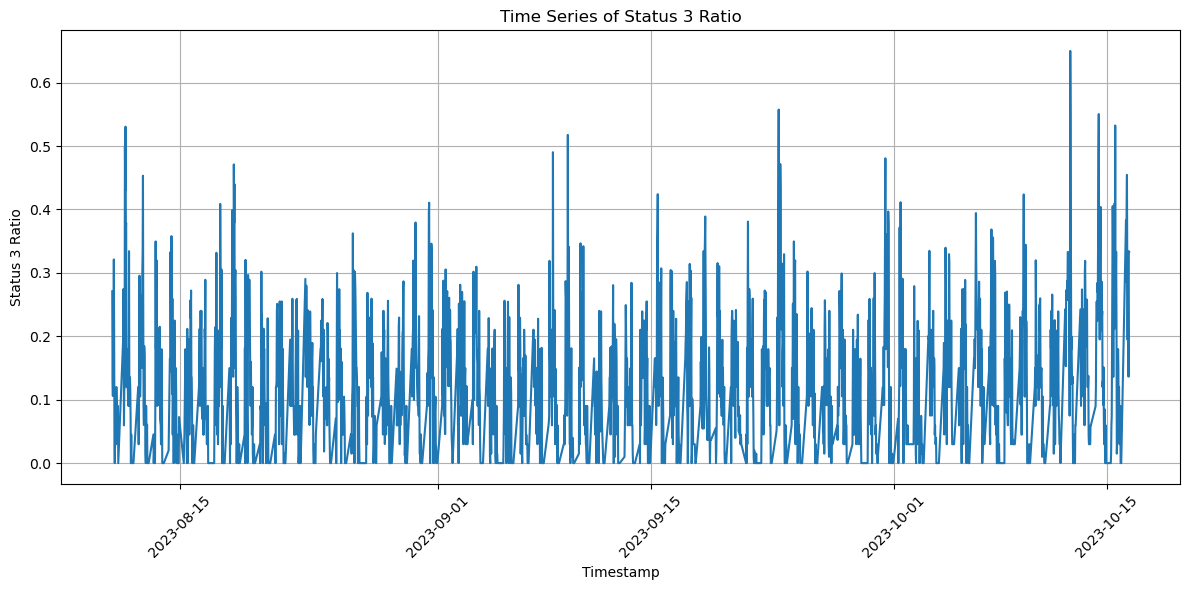

In [22]:
"""
Visualize charging station 
"""
# Ensure that the 'timestamp_rounded' is in datetime format for better plotting
specific_station_data_sorted['timestamp_rounded'] = pd.to_datetime(specific_station_data_sorted['timestamp_rounded'])

plt.figure(figsize=(12, 6))
plt.plot(specific_station_data_sorted['timestamp_rounded'], specific_station_data_sorted['status_3_ratio'], linestyle='-')
plt.title('Time Series of Status 3 Ratio')
plt.xlabel('Timestamp')
plt.ylabel('Status 3 Ratio')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate dates for better visibility
plt.tight_layout()  # Adjust layout to make room for rotated dates
plt.show()


In [23]:
"""
Save the dataframe
"""
with open('new_stations_df.pkl', 'wb') as f:
    pickle.dump(new_stations_time_series_df, f)